In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(Discriminator, self).__init__()
        self.l1 = torch.nn.Linear(in_features, 300)
        self.l2 = torch.nn.Linear(300, 200)
        self.l3 = torch.nn.Linear(200, 100)
        self.l4 = torch.nn.Linear(100, out_features)
        self.relu = torch.nn.ReLU()
        self.bce = torch.nn.BCEWithLogitsLoss()
        
    def forward(self, x):
        a1 = self.relu(self.l1(x))
        a2 = self.relu(self.l2(a1))
        a3 = self.relu(self.l3(a2))
        return self.l4(a3)
    
    def loss(self, x, y):
        y_hat_logits = self.forward(x)
        return self.bce(y_hat_logits, y)
    

In [2]:
x_1 = np.random.normal(size=(200,2))
x_2 = np.random.normal(loc=np.array([3.0,3.]), size=(200,2))

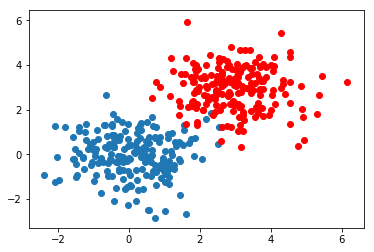

In [5]:
plt.scatter(x_1[:, 0], x_1[:, 1])
plt.scatter(x_2[:, 0], x_2[:, 1], c='r')

In [8]:
x = np.concatenate([x_1, x_2], axis=0)
y = np.concatenate([np.zeros(x_1.shape[0]), np.ones(x_2.shape[0])], axis=0)